# Learning the Bridge function


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt

from scipy.interpolate import interpn

from sklearn.metrics import r2_score, mean_squared_error as MSE, mean_absolute_error as MAE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tqdm.keras import TqdmCallback

In [2]:
def make_model(input_dim, lam=1e-5):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(32, activation='relu', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.add(Dense(1, activation='linear', kernel_regularizer=keras.regularizers.l2(l=lam)))
    model.summary()

    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

def train_model(model, X_train, y_train, y_var, batch_size=128, epochs=100, \
             save_file=False, training_curve=True, val_split=0.1):
    print("Learning MLP model with {} training points".format(len(y_train)))

    try:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, sample_weight=y_var, \
                            validation_split=val_split, verbose=0, callbacks=[TqdmCallback(verbose=1)])
    except KeyboardInterrupt:
        pass
    
    if save_file:
        model.save(save_file)  # creates a HDF5 file 'my_model.h5'
    
    if training_curve:
        # "Loss"
        plt.figure(figsize=(10,8))
        matplotlib.rcParams.update({'font.size': 15})
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
    
    return model

In [3]:
df_hard = pd.read_csv("datasets/hard-train.csv")
X_train_hard = df_hard[["avg_tcf","avg_dcf","fd_gr","avg_grad_icf",]].values
y_train_hard = df_hard[["avg_br"]].values
y_ivar_hard = (df_hard[["err_br"]].values**-2.).ravel()

In [4]:
df_soft = pd.read_csv("datasets/soft-train.csv")
X_train_soft = df_soft[["avg_tcf","avg_dcf","fd_gr","avg_grad_icf",]].values
y_train_soft = df_soft[["avg_br"]].values
y_ivar_soft = (df_soft[["err_br"]].values**-2.).ravel()

In [5]:
df_test_hard = pd.read_csv("datasets/hard-test.csv")
X_test_hard = df_test_hard[["avg_tcf","avg_dcf","fd_gr","avg_grad_icf",]].values
y_test_hard = df_test_hard[["avg_br"]].values

In [6]:
df_test_soft = pd.read_csv("datasets/soft-test.csv")
X_test_soft = df_test_soft[["avg_tcf","avg_dcf","fd_gr","avg_grad_icf",]].values
y_test_soft = df_test_soft[["avg_br"]].values

In [7]:
# hard = make_model(4)
# soft = make_model(4)

In [8]:
hard = load_model("models/hard.h5")
soft = load_model("models/soft.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
# hard = train_model(hard, X_train_hard, y_train_hard, y_ivar_hard, 
#                     epochs=100, save_file="models/hard.h5")

In [10]:
# soft = train_model(soft, X_train_soft, y_train_soft, y_ivar_soft, 
#                     epochs=100, save_file="models/soft.h5")

In [11]:
y_hard_hard = hard.predict(X_test_hard)
y_soft_hard = hard.predict(X_test_soft)
                          
y_hard_soft = soft.predict(X_test_hard)
y_soft_soft = soft.predict(X_test_soft)

r2_hard_hard = r2_score(y_hard_hard, y_test_hard)
r2_soft_hard = r2_score(y_soft_hard, y_test_soft)

r2_hard_soft = r2_score(y_hard_soft, y_test_hard)
r2_soft_soft = r2_score(y_soft_soft, y_test_soft)

r2_hnc_hard = r2_score(np.zeros_like(y_soft_soft), y_test_hard)
r2_hnc_soft = r2_score(np.zeros_like(y_soft_soft), y_test_soft)

rmse_hard_hard = np.sqrt(MSE(y_hard_hard, y_test_hard))
rmse_soft_hard = np.sqrt(MSE(y_soft_hard, y_test_soft))

rmse_hard_soft = np.sqrt(MSE(y_hard_soft, y_test_hard))
rmse_soft_soft = np.sqrt(MSE(y_soft_soft, y_test_soft))

rmse_hnc_hard = np.sqrt(MSE(np.zeros_like(y_soft_hard), y_test_hard))
rmse_hnc_soft = np.sqrt(MSE(np.zeros_like(y_soft_hard), y_test_soft))

mae_hard_hard = MAE(y_hard_hard, y_test_hard)
mae_soft_hard = MAE(y_soft_hard, y_test_soft)
mae_hard_soft = MAE(y_hard_soft, y_test_hard)
mae_soft_soft = MAE(y_soft_soft, y_test_soft)
mae_hnc_soft = MAE(np.zeros_like(y_soft_soft), y_test_soft)
mae_hnc_hard = MAE(np.zeros_like(y_soft_soft), y_test_hard)

In [12]:
print("          |  R2   |  RMSE |  MAE  ")
print("Hard-Hard | {:.3f} | {:.3f} | {:.3f}".format(r2_hard_hard, rmse_hard_hard, mae_hard_hard))
print("Soft-Hard | {:.3f} | {:.3f} | {:.3f}".format(r2_soft_hard, rmse_soft_hard, mae_soft_hard))
print("Hard-Soft | {:.3f} | {:.3f} | {:.3f}".format(r2_hard_soft, rmse_hard_soft, mae_hard_soft))
print("Soft-Soft | {:.3f} | {:.3f} | {:.3f}".format(r2_soft_soft, rmse_soft_soft, mae_soft_soft))
print("HNC-Soft  | {:.3f} | {:.3f} | {:.3f}".format(r2_hnc_soft, rmse_hnc_soft, mae_hnc_soft))
print("HNC-Hard  | {:.3f} | {:.3f} | {:.3f}".format(r2_hnc_hard, rmse_hnc_hard, mae_hnc_hard))

          |  R2   |  RMSE |  MAE  
Hard-Hard | 0.871 | 0.032 | 0.007
Soft-Hard | 0.011 | 0.475 | 0.049
Hard-Soft | 0.296 | 0.106 | 0.023
Soft-Soft | 0.916 | 0.033 | 0.009
HNC-Soft  | 0.000 | 0.116 | 0.038
HNC-Hard  | 0.000 | 0.092 | 0.019


In [13]:
def density_scatter(x , y, colours, ax = None, label=None, sort = True, log=True, bins = 40,  **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
        
    data , x_e, y_e = np.histogram2d(x, y, bins = bins)
    
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
    
    if log:
        z = np.log(z)    
    
    ax.scatter( x, y, c=z, cmap=colours, label=label, **kwargs )
    return ax

In [14]:
from matplotlib.colors import LinearSegmentedColormap

interval = np.linspace(0, 1)
colors = plt.get_cmap('Blues')(interval)
cmap_b = LinearSegmentedColormap.from_list('name', colors)
                       
colors = plt.get_cmap('Oranges')(interval)
cmap_o = LinearSegmentedColormap.from_list('name', colors)

colors = plt.get_cmap('Reds')(interval)
cmap_r = LinearSegmentedColormap.from_list('name', colors)

colors = plt.get_cmap('Greens')(interval)
cmap_g = LinearSegmentedColormap.from_list('name', colors)

/home/reag2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


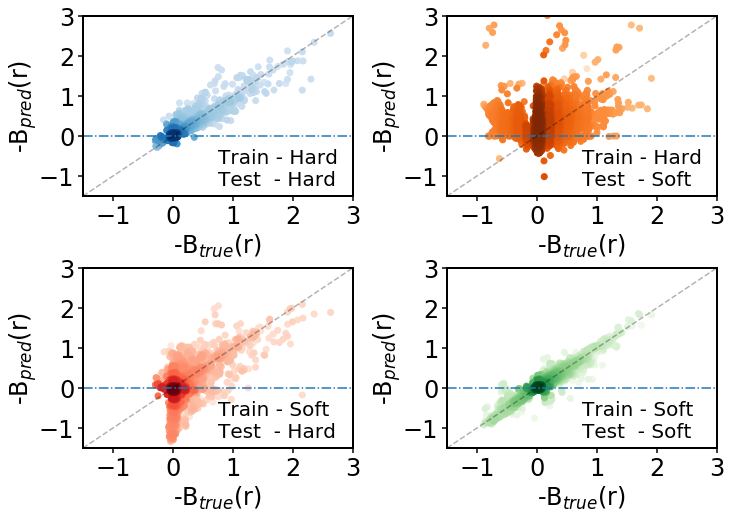

In [15]:
# plt.rc('font', family='serif')
plt.rc('font', size=24)
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1.5

fig, ax = plt.subplots(2,2, figsize=(10, 7.5))
plt.subplots_adjust(top=0.95, bottom=0.15, 
                    wspace=0.35, hspace=0.40,
                    left=0.10, right=0.98,)

density_scatter(-y_test_hard.ravel(), -y_hard_hard.ravel(), cmap_b, ax=ax[0,0])

density_scatter(-y_test_soft.ravel(), -y_soft_hard.ravel(), cmap_o, ax=ax[0,1])

density_scatter(-y_test_hard.ravel(), -y_hard_soft.ravel(), cmap_r, ax=ax[1,0])

density_scatter(-y_test_soft.ravel(), -y_soft_soft.ravel(), cmap_g, ax=ax[1,1]) 

ax[0,0].plot([-1.5, 3], [0, 0], linestyle="-.", color="tab:blue")
ax[0,0].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[0,0].set_xlabel('-B$_{true}$(r)')
ax[0,0].set_ylabel('-B$_{pred}$(r)', labelpad=0)
ax[0,0].set_xlim((-1.5,3))
ax[0,0].set_ylim((-1.5,3))
ax[0,0].set_xticks((-1,0,1,2,3))
ax[0,0].set_yticks((-1,0,1,2,3))

ax[0,1].plot([-1.5, 3], [0, 0], linestyle="-.", color="tab:blue")
ax[0,1].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[0,1].set_xlabel('-B$_{true}$(r)')
ax[0,1].set_ylabel('-B$_{pred}$(r)', labelpad=0)
ax[0,1].set_xlim((-1.5,3))
ax[0,1].set_ylim((-1.5,3))
ax[0,1].set_xticks((-1,0,1,2,3))
ax[0,1].set_yticks((-1,0,1,2,3))

ax[1,0].plot([-1.5, 3], [0, 0], linestyle="-.", color="tab:blue")
ax[1,0].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[1,0].set_xlabel('-B$_{true}$(r)')
ax[1,0].set_ylabel('-B$_{pred}$(r)', labelpad=0)
ax[1,0].set_xlim((-1.5,3))
ax[1,0].set_ylim((-1.5,3))
ax[1,0].set_xticks((-1,0,1,2,3))
ax[1,0].set_yticks((-1,0,1,2,3))

ax[1,1].plot([-1.5, 3], [0, 0], linestyle="-.", color="tab:blue")
ax[1,1].plot([-1.5, 3], [-1.5, 3], linestyle="--", color='k',  alpha=0.3)
ax[1,1].set_xlabel('-B$_{true}$(r)')
ax[1,1].set_ylabel('-B$_{pred}$(r)', labelpad=0)
ax[1,1].set_xlim((-1.5,3))
ax[1,1].set_ylim((-1.5,3))
ax[1,1].set_xticks((-1,0,1,2,3))
ax[1,1].set_yticks((-1,0,1,2,3))

# ax[0,0].legend(markerscale=1, fontsize=20, frameon=False, title="Train - Hard\nTest  - Hard", loc=4)
# ax[0,1].legend(markerscale=1, fontsize=20, frameon=False, title="Train - Hard\nTest  - Soft", loc=4)
# ax[1,0].legend(markerscale=1, fontsize=20, frameon=False, title="Train - Soft\nTest  - Hard", loc=4)
# ax[1,1].legend(markerscale=1, fontsize=20, frameon=False, title="Train - Soft\nTest  - Soft", loc=4)

ax[0,0].annotate("Train - Hard\nTest  - Hard", (0.5,0.06), xycoords='axes fraction', fontsize=20)
ax[0,1].annotate("Train - Hard\nTest  - Soft", (0.5,0.06), xycoords='axes fraction', fontsize=20)
ax[1,0].annotate("Train - Soft\nTest  - Hard", (0.5,0.06), xycoords='axes fraction', fontsize=20)
ax[1,1].annotate("Train - Soft\nTest  - Soft", (0.5,0.06), xycoords='axes fraction', fontsize=20)

# plt.tight_layout()

# plt.savefig("plots/compare_{}.png".format(datetime.now().strftime("%d-%m-%Y_%I-%M-%S_%p")))
plt.savefig("plots/compare-hard-soft.png")
plt.show()
